# Econ 281: Computational Tools in Macroeconomics

### Homework 3: Continuous Time

##### Youngdoo Choi (yoc005@ucsd.edu), April 2024

---

### 0. Classroom exercise

- Solve HJB using the explicit method

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import time

In [2]:
# Set structural parameters
class Parameters:
    def __init__(self):
        self.beta = 0.99
        self.rho = -np.log(self.beta)
        self.r = self.rho
        self.y = 1

params = Parameters()

In [3]:
# Set numerical parameters
class Num_parameters:
    def __init__(self):
        self.amin = 0.1
        self.amax = 1.0
        self.agridsize = 100
        self.agrid = np.linspace(self.amin, self.amax, self.agridsize)
        self.grid_step = self.agrid[1] - self.agrid[0]
        self.delta = 0.01 # updating factor for the explicit method
        self.Delta = 0.5 # updating factor for the implicit method
        self.max_iter = 10000
        self.tol = 1e-6

num_params = Num_parameters()

In [4]:
# Define utility functions
def utility(c):
    return np.log(c)

def marginal_utility(c):
    return 1/c

def inv_marginal_utility(x):
    return 1/x

In [5]:
# Define a function to compute Vprime using upwind scheme
def Vprime_upwind(V_old, params, num_params):

    V_diff = (V_old[1:] - V_old[:-1]) / num_params.grid_step

    # Compute using forward differences
    forward_boundary = 0
    Vp_forward = np.append(V_diff, forward_boundary)
    c_forward = inv_marginal_utility(np.maximum(1e-10, Vp_forward))
    drift_forward = params.r*num_params.agrid + params.y - c_forward

    # Compute using backward difference
    backward_boundary = inv_marginal_utility(params.r*num_params.agrid[0] + params.y)
    Vp_backward = np.insert(V_diff, 0, backward_boundary)
    c_backward = inv_marginal_utility(np.maximum(1e-10, Vp_backward))
    drift_backward = params.r*num_params.agrid + params.y - c_backward

    # Compute Vp at steady states
    Vp_bar = marginal_utility(params.r*num_params.agrid + params.y)

    # Compute Vp
    Vprime = Vp_forward * (drift_forward > 0) + Vp_backward * (drift_backward < 0) + Vp_bar * (1-(drift_forward > 0)-(drift_backward < 0))
    consumption = inv_marginal_utility(Vprime)

    return Vprime, consumption

In [6]:
# Define a function to update value functions
def HJB_Operator(V_old, params, num_params):

    # Compute derivatives and optimal policies
    Vprime, consumption = Vprime_upwind(V_old, params, num_params)
    saving = (1+params.r)*num_params.agrid + params.y - consumption
    
    # Update the value function
    diff = utility(consumption) + Vprime * (params.r*num_params.agrid + params.y - consumption) - params.rho*V_old 
    V_new = V_old + num_params.delta*diff

    return V_new, consumption, saving

In [7]:
# Define a function to converge value functions
def HJB_Iteration(V_0, params, num_params, progress=True, prog_freq=1000):

    start_time = time.time()
    V_old = V_0

    # Iterate the HJB operator until convergence
    for iter in range(num_params.max_iter):
        V_new, consumption, saving = HJB_Operator(V_old, params, num_params)

        error = np.max(np.abs(V_new - V_old))
        if error < num_params.tol:
            print(f"HJB_Iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
            return V_new, consumption, saving
        else:
            V_old = V_new

        if progress == True and iter % prog_freq == 0:
            print(f"HJB_Iteration in progress: iter {iter}, error {error}")

    if iter == num_params.max_iter - 1:
        print("HJB_Iteration Error: No convergence")

In [8]:
V_0 = np.linspace(0, 1, num_params.agridsize)
V_star, consumption, saving = HJB_Iteration(V_0, params, num_params)

HJB_Iteration in progress: iter 0, error 6.867299437007812e-05
HJB_Iteration in progress: iter 1000, error 4.285552699390127e-05
HJB_Iteration in progress: iter 2000, error 1.0566316458487934e-05
HJB_Iteration in progress: iter 3000, error 4.434266820577126e-06
HJB_Iteration in progress: iter 4000, error 2.3351101169494237e-06
HJB_Iteration in progress: iter 5000, error 1.386662079730372e-06
HJB_Iteration done: 5717 iter, 0.23 seconds


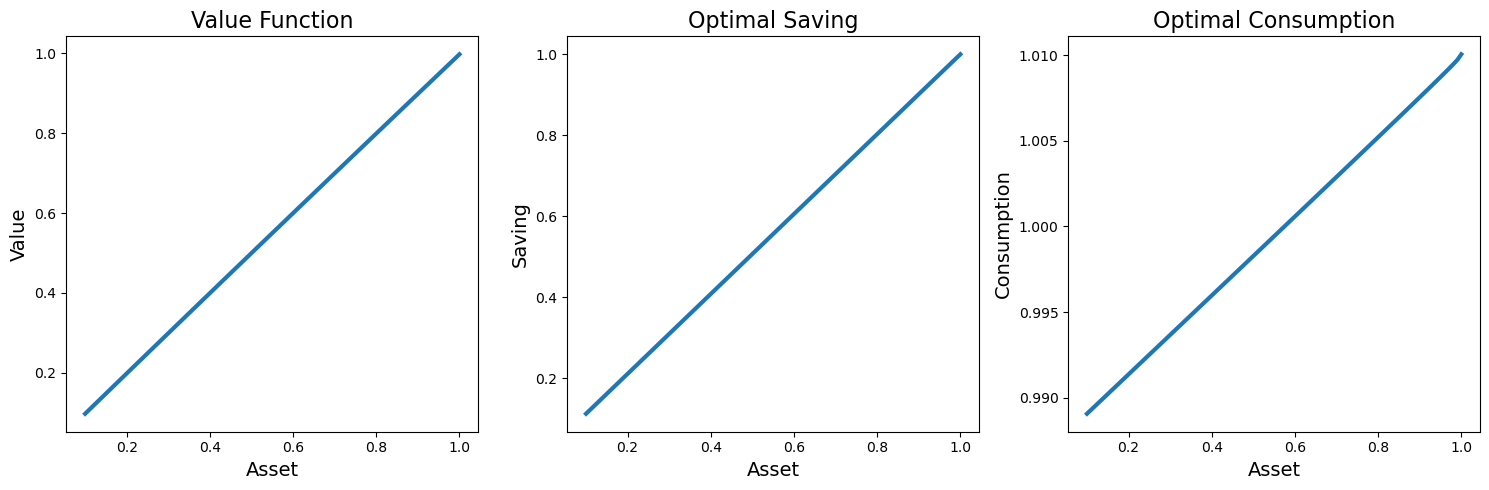

In [9]:
# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(num_params.agrid, saving, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(num_params.agrid, consumption, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

---

### Problem 1: Solve HJB using the implicit method

In [10]:
# Define a function to construct the A matrix using upwind scheme
def Construct_Amatrix(V_old, params, num_params):

    V_diff = (V_old[1:] - V_old[:-1]) / num_params.grid_step

    # Compute using forward differences
    forward_boundary = 0
    Vp_forward = np.append(V_diff, forward_boundary)
    c_forward = inv_marginal_utility(np.maximum(1e-10, Vp_forward))
    drift_forward = params.r*num_params.agrid + params.y - c_forward

    # Compute using backward difference
    backward_boundary = inv_marginal_utility(params.r*num_params.agrid[0] + params.y)
    Vp_backward = np.insert(V_diff, 0, backward_boundary)
    c_backward = inv_marginal_utility(np.maximum(1e-10, Vp_backward))
    drift_backward = params.r*num_params.agrid + params.y - c_backward

    # Compute Vp at steady states
    Vp_bar = marginal_utility(params.r*num_params.agrid + params.y)

    # Compute consumption
    Vprime = Vp_forward * (drift_forward > 0) + Vp_backward * (drift_backward < 0) + Vp_bar * (1-(drift_forward > 0)-(drift_backward < 0))
    consumption = inv_marginal_utility(Vprime)

    # Compute the A matrix
    A_mat = np.zeros((num_params.agridsize, num_params.agridsize))
    A_mat[0, 0] = (np.minimum(drift_backward[0], 0) - np.maximum(drift_forward[0], 0)) / num_params.grid_step
    A_mat[0, 1] = np.maximum(drift_forward[0], 0) / num_params.grid_step
    A_mat[-1, -2] = -np.minimum(drift_backward[-1], 0) / num_params.grid_step
    A_mat[-1, -1] = (np.minimum(drift_backward[-1], 0) - np.maximum(drift_forward[-1], 0)) / num_params.grid_step
    for i in range(1, num_params.agridsize - 1):
        A_mat[i, i-1] = -np.minimum(drift_backward[i], 0) / num_params.grid_step
        A_mat[i, i] = (np.minimum(drift_backward[i], 0) - np.maximum(drift_forward[i], 0)) / num_params.grid_step
        A_mat[i, i+1] = np.maximum(drift_forward[i], 0) / num_params.grid_step

    return A_mat, consumption

In [11]:
# Define a function to update value functions
def HJB_Operator_Implicit(V_old, params, num_params):

    # Construct the A matrix
    A_mat, consumption = Construct_Amatrix(V_old, params, num_params)
    saving = (1+params.r)*num_params.agrid + params.y - consumption
    
    # Update the value function
    coef_mat = (params.rho + 1/num_params.Delta) * np.eye(num_params.agridsize) - A_mat
    V_new = np.dot(np.linalg.inv(coef_mat), (utility(consumption) + 1/num_params.Delta * V_old))
    return V_new, consumption, saving

In [12]:
# Define a function to converge value functions
def HJB_Iteration_Implicit(V_0, params, num_params, progress=True, prog_freq=1000):

    start_time = time.time()
    V_old = V_0

    # Iterate the HJB operator until convergence
    for iter in range(num_params.max_iter):
        V_new, consumption, saving = HJB_Operator_Implicit(V_old, params, num_params)

        error = np.max(np.abs(V_new - V_old))
        if error < num_params.tol:
            print(f"HJB_Iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
            return V_new, consumption, saving
        else:
            V_old = V_new

        if progress == True and iter % prog_freq == 0:
            print(f"HJB_Iteration in progress: iter {iter}, error {error}")

    if iter == num_params.max_iter - 1:
        print("HJB_Iteration Error: No convergence")

In [13]:
V_0 = np.linspace(0, 1, num_params.agridsize)
V_star, consumption, saving = HJB_Iteration_Implicit(V_0, params, num_params)

HJB_Iteration in progress: iter 0, error 0.00341648086478825
HJB_Iteration done: 642 iter, 0.66 seconds


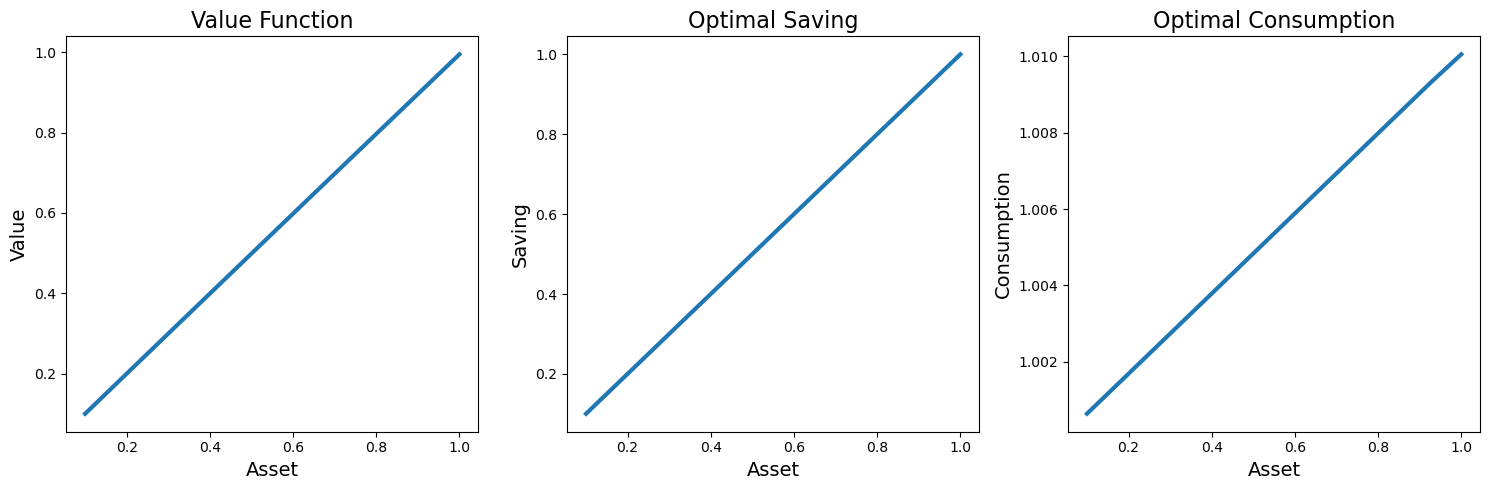

In [14]:
# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(num_params.agrid, saving, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(num_params.agrid, consumption, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

**Takeaways**:

- The implicit method is supposed to be faster, but it is slower here. 

- This is because the codes for constructing the A matrix and computing the inverse matrix is costly here. 

- Later I can find more efficient way.

---

### Problem 2: Compare with the discrete time model

- Adjust parameters in the continuous model to match the discrete model

- If we set $\Delta = 1$ in the HJB equation, we should get the same results with the discrete model by definition:

\begin{equation*}
\rho v(x_t) = max_{y_t} u(y_t) + (1-\rho) \frac{v(x_{t+1}) - v(x_t)}{x_{t+1} - x_t} \frac{x_{t+1} - x_t}{1}
\end{equation*}

- However, we need to adjust the discount factor to corresponding discrete one

In [15]:
# Redefine discounting factors
params.rho = (1/params.beta) - 1
params.r = params.rho

HJB_Iteration in progress: iter 0, error 0.0034191958230681023
HJB_Iteration done: 641 iter, 0.73 seconds


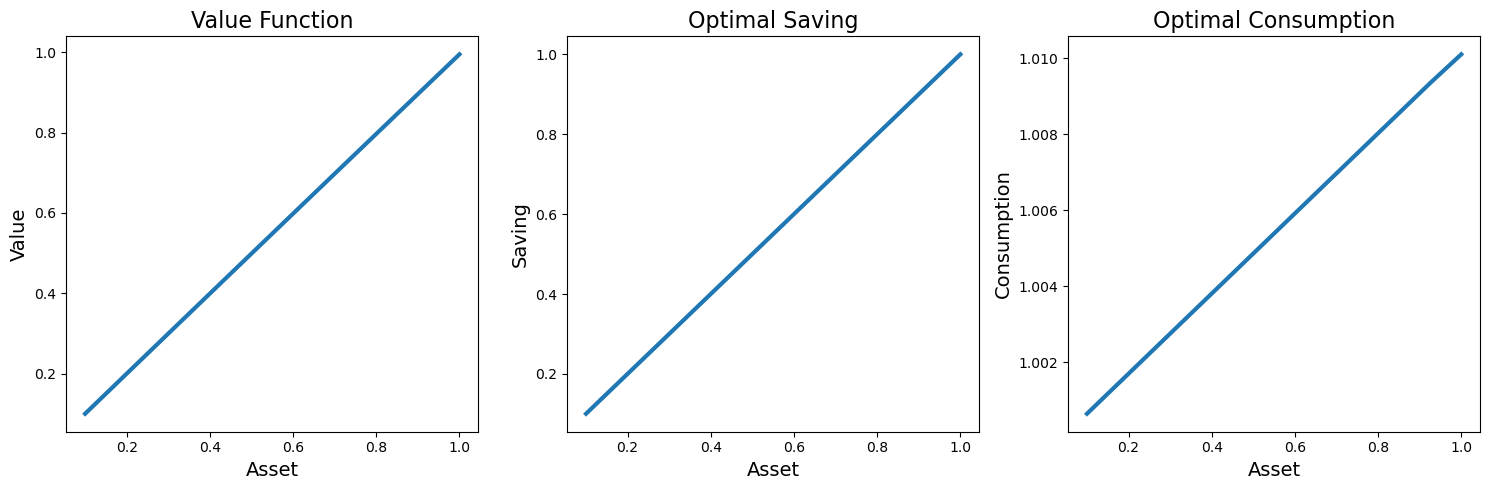

In [16]:
# Solve the continuous model again
V_0 = np.linspace(0, 1, num_params.agridsize)
V_star, consumption, saving = HJB_Iteration_Implicit(V_0, params, num_params)

# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(num_params.agrid, saving, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(num_params.agrid, consumption, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

Solve the discrete model and compare

In [17]:
# Define Bellman operator
def Bellman_Operator(V_old, params, num_params):

    # Allocate empty outcome vectors
    V_new = np.empty(num_params.agridsize)
    saving = np.empty(num_params.agridsize)

    # Interpolate the value function
    V_interp = interp1d(num_params.agrid, V_old, kind='linear', bounds_error=False, fill_value='extrapolate')

    # Solve the problem
    for (aidx, a) in enumerate(num_params.agrid):
        Obj = lambda a_prime: -(utility((1+params.r)*a+params.y-a_prime) + params.beta*V_interp(a_prime)) # objective function
        res = minimize_scalar(Obj, bounds=(num_params.agrid[0], num_params.agrid[-1]), method='bounded')
        V_new[aidx] = -res.fun
        saving[aidx] = res.x
    consumption = (1+params.r)*num_params.agrid + params.y - saving

    return V_new, saving, consumption

In [18]:
# Define VFI function
def VFI(V_0, params, num_params, progress=True, prog_freq=100, howard=1):

    start_time = time.time()
    V_old = V_0

    # Iterate the Bellman operator until convergence
    for iter in range(num_params.max_iter):
        if iter % howard == 0:
            V_new, saving, consumption = Bellman_Operator(V_old, params, num_params)
        else:
            V_interp = interp1d(num_params.agrid, V_old, kind='linear', bounds_error=False, fill_value='extrapolate')
            V_new = utility(consumption) + params.beta*V_interp(saving)

        # Check convergence & update
        error = np.max(np.abs(V_new - V_old))
        if error < num_params.tol:
            V_star, saving, consumption = Bellman_Operator(V_new, params, num_params)
            elapsed_time = "{:.2f}".format(time.time() - start_time)
            print(f"VFI done: {iter} iter, {elapsed_time} seconds")
            return V_star, saving, consumption, elapsed_time
        else:
            V_old = V_new

        # Show progress
        if progress == True and iter % prog_freq == 0:
            print(f"VFI in progress: iter {iter}, error {error}")
    
    if iter == num_params.max_iter - 1:
        print("VFI Error: No convergence")

In [19]:
# Solve VFI without Howard's improvement
V_0 = np.linspace(0, 1, num_params.agridsize)
V_VFI, saving_VFI, consumption_VFI, time_VFI = VFI(V_0, params, num_params)

VFI in progress: iter 0, error 0.005800931306786161
VFI in progress: iter 100, error 5.584717312885623e-05
VFI in progress: iter 200, error 1.4128250992381797e-05
VFI in progress: iter 300, error 4.734641520329208e-06
VFI in progress: iter 400, error 1.6899248027058e-06
VFI done: 452 iter, 10.61 seconds


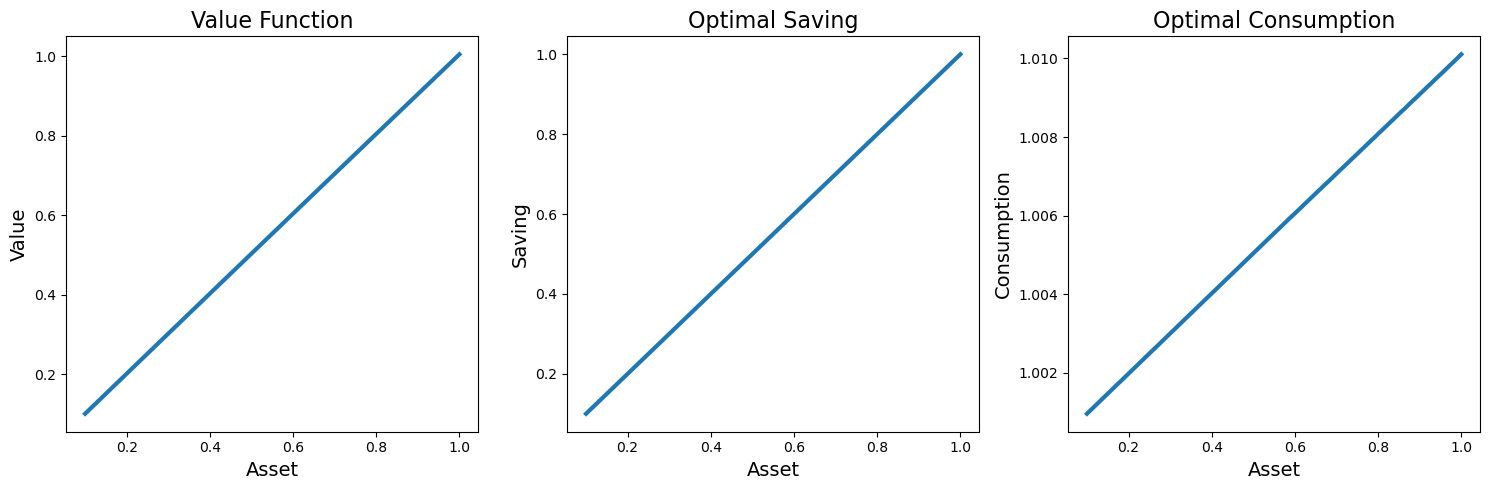

In [20]:
# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_VFI, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(num_params.agrid, saving_VFI, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(num_params.agrid, consumption_VFI, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

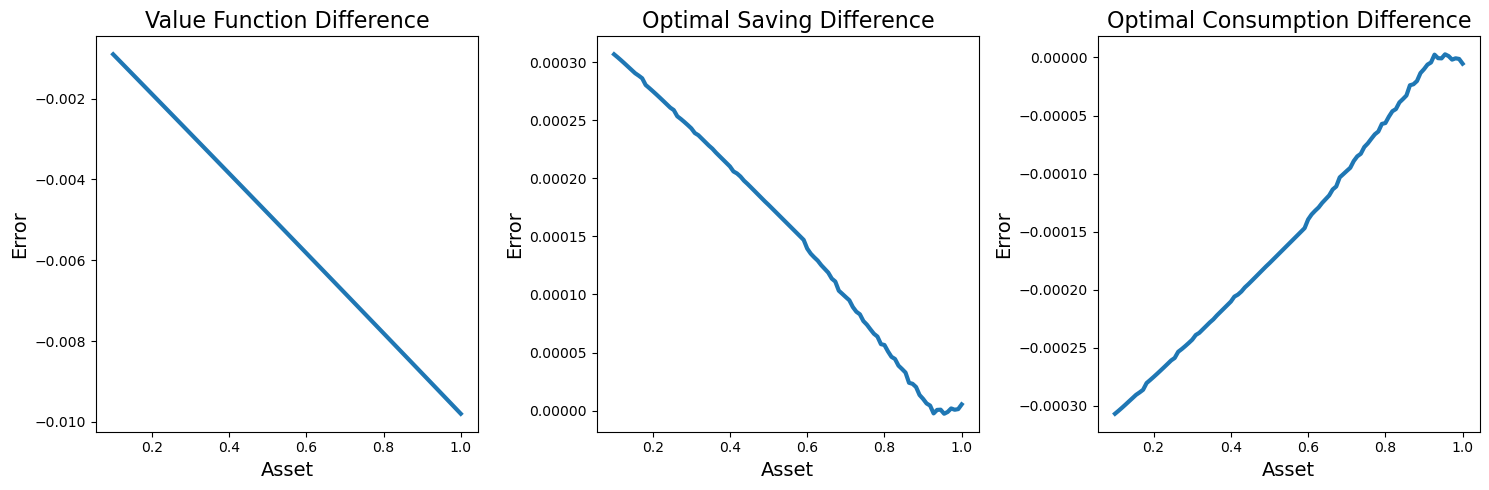

In [21]:
# Compare results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star-V_VFI, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Error', fontsize=14)
axs[0].set_title('Value Function Difference', fontsize=16)

axs[1].plot(num_params.agrid, saving-saving_VFI, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Error', fontsize=14)
axs[1].set_title('Optimal Saving Difference', fontsize=16)

axs[2].plot(num_params.agrid, consumption-consumption_VFI, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Error', fontsize=14)
axs[2].set_title('Optimal Consumption Difference', fontsize=16)

plt.tight_layout()
plt.show()

**Takeaways**:

- There is still a non-negligible difference between the two methods

---

### Problem 3 & 4: To be done